# Classification of Movies 

Classifying the movie as animated or not animated on the basis of crew job titles.
This is the inspiration of this dataset (as described in the data description)

Firstly, preprocessed data and prepared it. Then used NLP and classification models for accomplishing the task.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from sklearn.model_selection import train_test_split

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tmdb-movie-metadata/tmdb_5000_movies.csv
/kaggle/input/tmdb-movie-metadata/tmdb_5000_credits.csv


### Loading the Dataset as pandas.DataFrame

In [2]:
df_credits = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_credits.csv')
df_movies = pd.read_csv('../input/tmdb-movie-metadata/tmdb_5000_movies.csv')

In [3]:
df_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  4803 non-null   int64 
 1   title     4803 non-null   object
 2   cast      4803 non-null   object
 3   crew      4803 non-null   object
dtypes: int64(1), object(3)
memory usage: 150.2+ KB


In [4]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

In [5]:
df_credits.rename(columns = {'movie_id':'id'}, inplace = True)

The column 'title' and 'original_title' are equivalent
So dropping the 'original_title' column

In [6]:
df_movies.drop('original_title', axis = 1, inplace = True)

### Merging the Datasets

Merging the 2 datasets on the columns 'id' and 'title' as primary key 

In [7]:
df_merged = pd.merge(df_credits, df_movies, on = ['id','title'])

### Handling the Json Columns

Applying the literal_eval function of ast on all the json columns

In [8]:
from ast import literal_eval

json_cols = ['cast', 'crew', 'genres', 'keywords','production_companies', 'production_countries','spoken_languages']

for col in json_cols:
    df_merged[col] = df_merged[col].apply(literal_eval)

### Extracting the features from Json Columns

1. Genres list (from Genres column)
2. Jobs (from Crew column)
3. Percentage of voice artists among total cast (from cast column)

#### Helper Functions for the same

In [9]:
def get_genre(x):
    if(isinstance(x, list)):
        genre = [i['name'] for i in x]
    
    return genre

def get_jobs(x):
    if(isinstance(x, list)):
        jobs = [i['job'] for i in x]
    return jobs

def get_characternames(x):
    if(isinstance(x, list)):
        chr_name = [i['character'] for i in x]
        countc = 0
        for j in chr_name:
            if('(voice)' in j):
                countc += 1
        if(len(chr_name)!=0):
            return (countc/len(chr_name))
        else:
            return 0
        
def get_labels(x):
    if(len(x)==0):
        return np.nan
    elif('Animation' in x):
        return 1
    else:
        return 0

def get_costume_labels(x):
    if 'Costume Design' in x:
        return 1
    else:
        return 0
    
def get_genre_cd(x):
    if(isinstance(x, list)):
        dept = [i['department'] for i in x]
    if 'Lighting' in dept:
        return 0
    else:
        return 1

In [10]:
df_merged['genres'] = df_merged['genres'].apply(get_genre)
df_merged['crew_jobs'] = df_merged['crew'].apply(get_jobs)
df_merged['percent_of_voice_artists'] = df_merged['cast'].apply(get_characternames)
df_merged['labels'] = df_merged['genres'].apply(get_labels)
df_merged['costume'] = df_merged['crew_jobs'].apply(get_costume_labels)
df_merged['lighting_dept'] = df_merged['crew'].apply(get_genre_cd)

Rounding off the percentage to 3 decimal places

In [11]:
for x in range(0,len(df_merged['percent_of_voice_artists'])):
    df_merged['percent_of_voice_artists'][x] = np.round(df_merged['percent_of_voice_artists'][x],3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Dropping the movies which are labelled as None

There are 28 such movies

In [12]:
df_merged.labels.isna().sum()

28

In [13]:
idxsc = df_merged[((df_merged.labels != 1) & (df_merged.labels != 0))].index
df_merged.drop(idxsc, inplace = True)
df_merged.reset_index(drop= True, inplace= True)

In [14]:
df_merged.isna().sum()

id                             0
title                          0
cast                           0
crew                           0
budget                         0
genres                         0
homepage                    3068
keywords                       0
original_language              0
overview                       3
popularity                     0
production_companies           0
production_countries           0
release_date                   0
revenue                        0
runtime                        2
spoken_languages               0
status                         0
tagline                      819
vote_average                   0
vote_count                     0
crew_jobs                      0
percent_of_voice_artists       0
labels                         0
costume                        0
lighting_dept                  0
dtype: int64

In [15]:
AnimatedMoviesCount = np.sum(df_merged['labels'] == 1)
NotAnimatedMoviesCount = np.sum(df_merged['labels'] == 0)

print("Number of Animated Movies are: ", AnimatedMoviesCount)
print("Number of Not Animated Movies are: ", NotAnimatedMoviesCount)

Number of Animated Movies are:  234
Number of Not Animated Movies are:  4541


In [16]:
df_merged.costume.value_counts()

1    2472
0    2303
Name: costume, dtype: int64

In [17]:
df_merged.lighting_dept.value_counts()

1    3881
0     894
Name: lighting_dept, dtype: int64

In [18]:
c = np.where(df_merged.labels==1)[0]
sum_budget = 0
for x in c:
    sum_budget += df_merged.budget[x]
avg_budget = sum_budget/len(c)
print("Average Budget of Animated Movie: ",str(avg_budget))

Average Budget of Animated Movie:  66465901.94871795


### Taking into account only those movies having atleast 7 crew members

So as to handle the quality of training data
Tested for multiple values, but 7 yielded best result

In [19]:
idx=[]
for x in range(0,df_merged.shape[0]):
    if len(df_merged.crew_jobs[x])>7:
        idx.append(x)
print("Number of Movies with more than 7 crew members: ",str(len(idx)))

df = df_merged.iloc[idx,:]

Number of Movies with more than 7 crew members:  3653


In [20]:
AnimatedMoviesCount2 = np.sum(df['labels'] == 1)
NotAnimatedMoviesCount2 = np.sum(df['labels'] == 0)

print("Number of Animated Movies are: ", AnimatedMoviesCount2)
print("Number of Not Animated Movies are: ", NotAnimatedMoviesCount2)

Number of Animated Movies are:  193
Number of Not Animated Movies are:  3460


Converting 'crew_jobs' from list to string (in lower form) via join function

In [21]:
def join_strings(x):
    return ", ".join(x)

def str_lower(x):
    return x.lower()

df['crew_jobs'] = df['crew_jobs'].apply(join_strings)
df['crew_jobs'] = df['crew_jobs'].apply(str_lower)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [22]:
df['labels'].value_counts()

0.0    3460
1.0     193
Name: labels, dtype: int64

### Model to classify Movie 

Classifying a movie as animated or not based on the crew job titles (using the data prepared above)

In [23]:
X1 = df['crew_jobs']
Y1 = df['labels']

In [24]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, Y1, test_size=0.20, random_state=53)

In [25]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt 

def score_output(y_test, y_pred):
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    clf_report = metrics.classification_report(y_test, y_pred)
    print(cm)
    print(clf_report)
    accuracy = accuracy_score(y_test, y_pred)
    print('The Accuracy on The Test Set is: %s' % accuracy)

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, fmt='d', cmap = 'inferno'); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Non-Animated', 'Animated']); ax.yaxis.set_ticklabels(['Non-Animated', 'Animated']);

In [26]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [27]:
from spacy.lang.en import STOP_WORDS
stop_words_str = " ".join(STOP_WORDS)
stop_words_lemma = set(word.lemma_ for word in nlp(stop_words_str))

additional_words = ['editor', 'director', 'producer', 'writer', 'assistant', 'sound']

for word in additional_words:
    stop_words_lemma = stop_words_lemma.union({word})

In [28]:
def lemmatizer(text):
     return [word.lemma_ for word in nlp(text)]

**Without Stop Words**

Without Stop Words
Training accuracy: 0.9873374401095141
[[699   1]
 [  8  23]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       700
         1.0       0.96      0.74      0.84        31

    accuracy                           0.99       731
   macro avg       0.97      0.87      0.91       731
weighted avg       0.99      0.99      0.99       731

The Accuracy on The Test Set is: 0.987688098495212


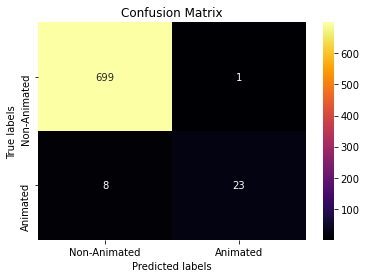

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

bow = TfidfVectorizer(ngram_range = (1,1))

pipe = Pipeline([('bag_of_words', bow),('classifier', SVC())])
pipe.fit(X_train1,y_train1)

print("Without Stop Words")
print('Training accuracy: {}'.format(pipe.score(X_train1,y_train1)))
y_pred = pipe.predict(X_test1)
score_output(y_test1, y_pred)

**With Stop Words**

/opt/conda/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:386: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['pron'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


With Stop Words
Training accuracy: 0.9876796714579056
[[699   1]
 [  9  22]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       700
         1.0       0.96      0.71      0.81        31

    accuracy                           0.99       731
   macro avg       0.97      0.85      0.90       731
weighted avg       0.99      0.99      0.99       731

The Accuracy on The Test Set is: 0.9863201094391245


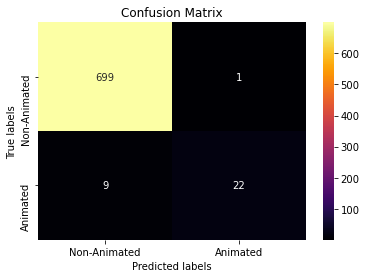

In [30]:
bow = TfidfVectorizer(ngram_range = (1,1), stop_words = stop_words_lemma)

pipe2 = Pipeline([('bag_of_words', bow),('classifier', SVC())])
pipe2.fit(X_train1,y_train1)


print("With Stop Words")
print('Training accuracy: {}'.format(pipe2.score(X_train1,y_train1)))
y_pred2 = pipe2.predict(X_test1)
score_output(y_test1, y_pred2)

It is evident from above results, SVM without stop words yields better resultd in terms of Recall, F1 score and Accuracy (Taking into count class imbalance and overfitting issues)

Thus, we can continue with SVM without stop words